In [1]:
library(openxlsx)
library(gridExtra)
library(dplyr)
library(lattice)

Warning message:
"package 'gridExtra' was built under R version 4.0.5"
Warning message:
"package 'dplyr' was built under R version 4.0.5"

Attaching package: 'dplyr'


The following object is masked from 'package:gridExtra':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




I will begin by reading csv files and merging them into one table

In [2]:
sales <- read.csv('C:/Users/kdirg/Downloads/Forecasting FuturePros/sales.csv')
features <- read.csv('C:/Users/kdirg/Downloads/Forecasting FuturePros/features.csv') 
stores <- read.csv('C:/Users/kdirg/Downloads/Forecasting FuturePros/stores.csv')

In [3]:
dat <- left_join(sales, stores, by = 'Store')
dat <- left_join(dat, features, by = c('Store', 'Date'))

Data correction. For attributes "Isholiday": False = 0, True = 1.
For attribute "Type": "A" = 0, "B" = 1, "C" = 2

In [4]:
dat[dat=="FALSE"] <- 0
dat[dat=="TRUE"] <- 1
dat[dat=="A"] <- 0
dat[dat=="B"] <- 1
dat[dat=="C"] <- 2
dat$Size <- as.numeric(dat$Size)
dat$Type <- as.numeric(dat$Type)
dat$Date <- as.Date(dat$Date, "%d/%m/%Y")
dat$Date <- as.numeric(dat$Date)

Basic information about Weekly Sales:

Minimum value = -4988.94 
Maximum value = 693099.4 
Average value = 15981.26 
Median = 7612.03 


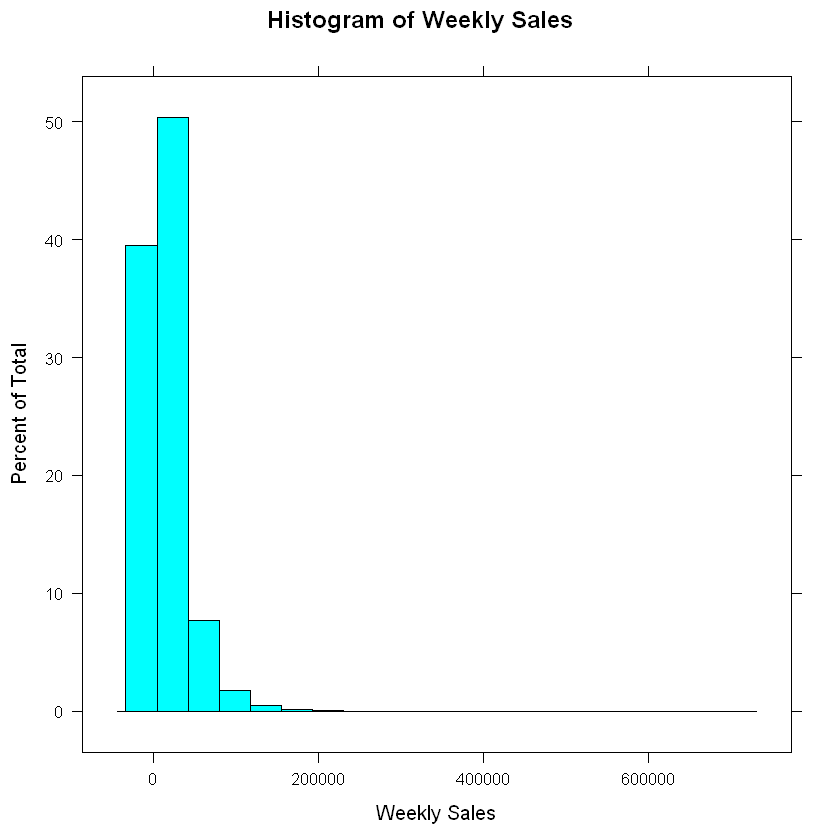

In [14]:
cat('Minimum value =', min(dat$Weekly_Sales), "\n")
cat('Maximum value =', max(dat$Weekly_Sales), "\n")
cat('Average value =', mean(dat$Weekly_Sales), "\n")
cat('Median =', median(dat$Weekly_Sales), "\n")

options(scipen=999)
histogram(dat$Weekly_Sales, xlab = "Weekly Sales", main = "Histogram of Weekly Sales")

I will filter data which is above average and analyse its properties

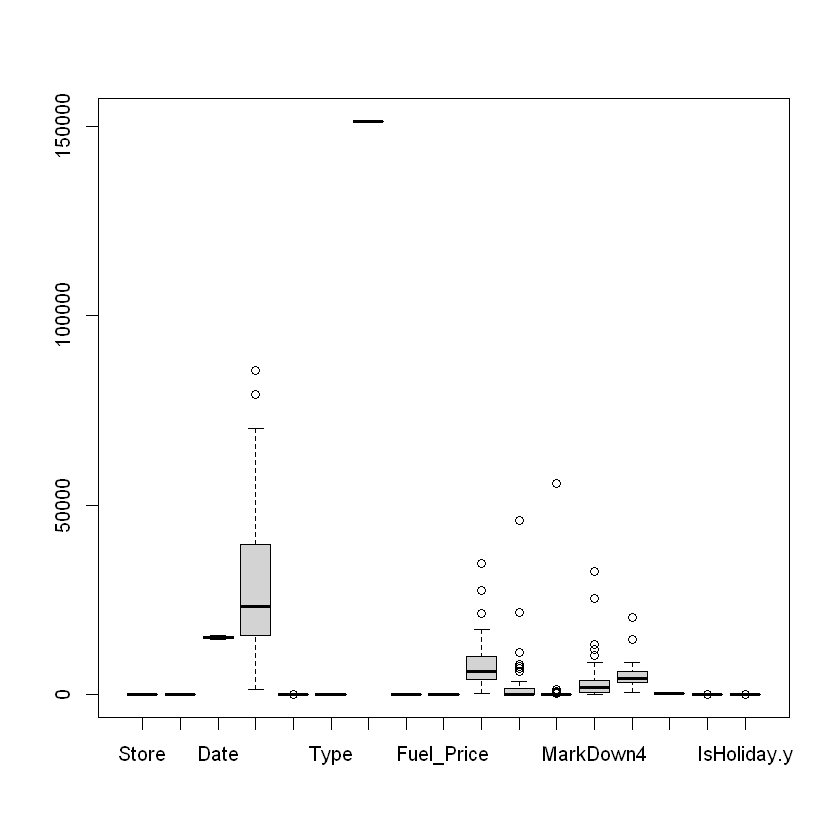

In [15]:
dat_above_av <- dat[1:769,]
boxplot(dat_above_av)

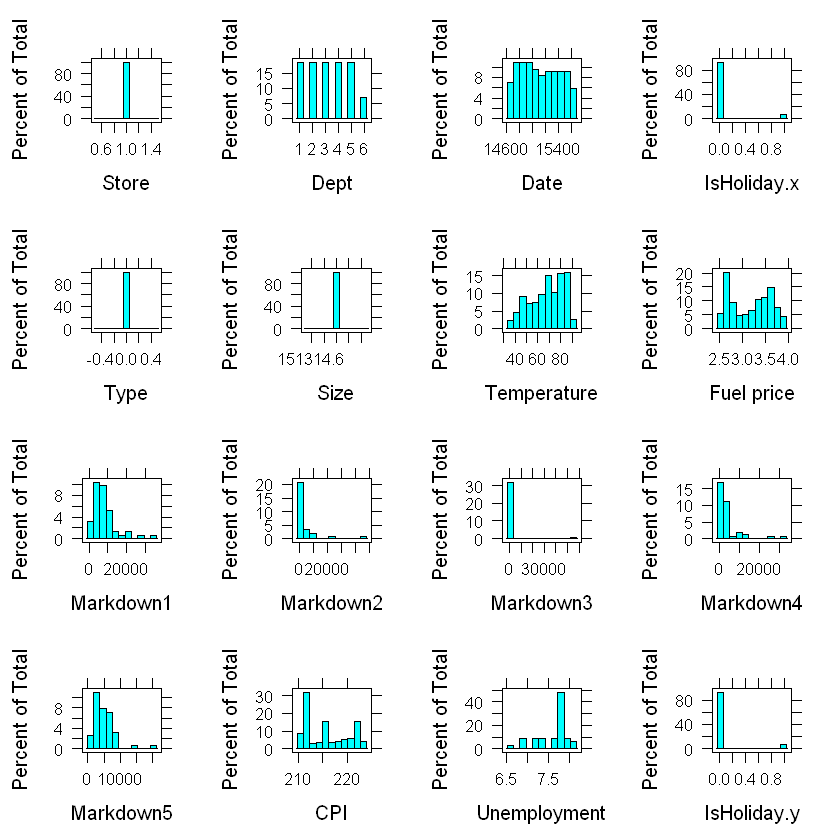

In [17]:
p1 <- histogram(dat_above_av$Store, xlab = "Store")
p2 <- histogram(dat_above_av$Dept, xlab = "Dept")
p3 <- histogram(dat_above_av$Date, xlab = "Date")
p4 <- histogram(dat_above_av$IsHoliday.x, xlab = "IsHoliday.x")
p5 <- histogram(dat_above_av$Type, xlab = "Type")
p6 <- histogram(dat_above_av$Size, xlab = "Size")
p7 <- histogram(dat_above_av$Temperature, xlab = "Temperature")
p8 <- histogram(dat_above_av$Fuel_Price, xlab = "Fuel price")
p9 <- histogram(dat_above_av$MarkDown1, xlab = "Markdown1")
p10 <- histogram(dat_above_av$MarkDown2, xlab = "Markdown2")
p11 <- histogram(dat_above_av$MarkDown3, xlab = "Markdown3")
p12 <- histogram(dat_above_av$MarkDown4, xlab = "Markdown4")
p13 <- histogram(dat_above_av$MarkDown5, xlab = "Markdown5")
p14 <- histogram(dat_above_av$CPI, xlab = "CPI")
p15 <- histogram(dat_above_av$Unemployment, xlab = "Unemployment")
p16 <- histogram(dat_above_av$IsHoliday.y, xlab = "IsHoliday.y")

grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10,
             p11, p12, p13, p14, p15, p16, nrow = 4)

Finding out correlation between variables:

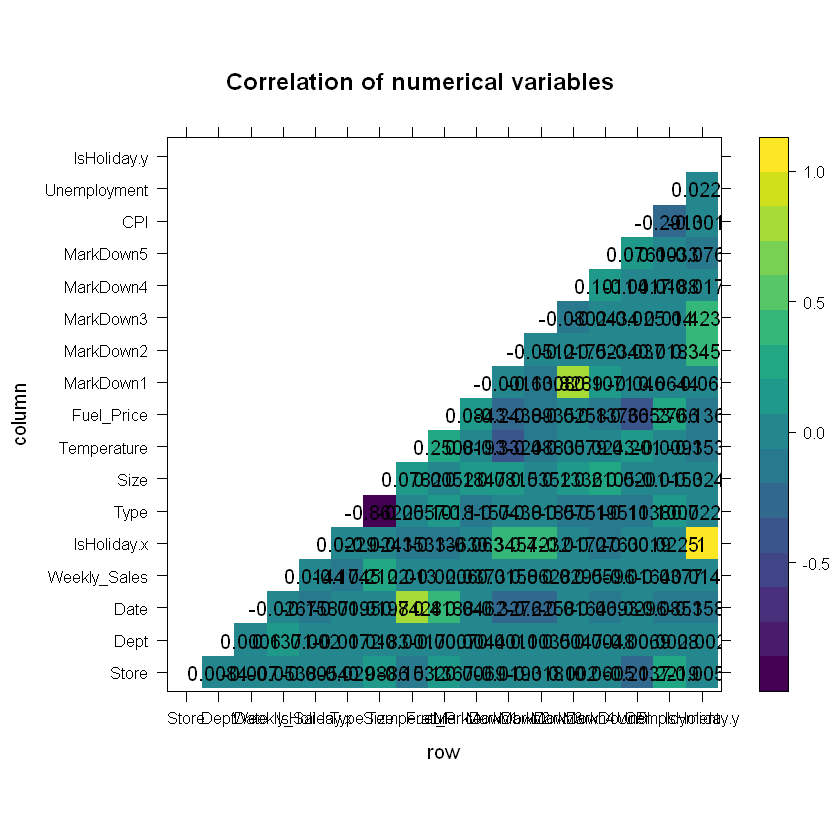

In [18]:
myPanel <- function(x, y, z, ...){
  lattice::panel.levelplot(x,y,z,...)
  my_text <- ifelse(!is.na(z), paste0(round(z, 4)), "")
  lattice::panel.text(x, y, my_text)
}

mask = cor(dat, use = "complete.obs")
mask[upper.tri(mask, diag = TRUE)] <- NA
lattice::levelplot(mask, 
                   panel = myPanel, 
                   col.regions = viridisLite::viridis(100), 
                   main = 'Correlation of numerical variables')

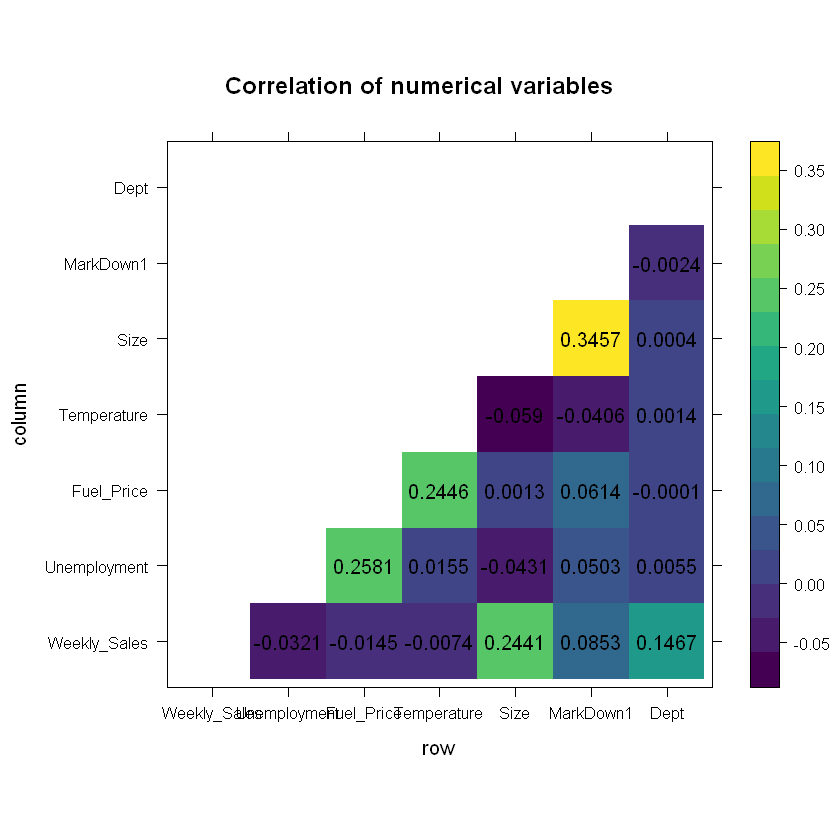

In [19]:
plt_cols <- c("Weekly_Sales", "Unemployment", "Fuel_Price", "Temperature", "Size", "MarkDown1", "Dept")

mask = cor(dat[, plt_cols], use = "complete.obs")
mask[upper.tri(mask, diag = TRUE)] <- NA
lattice::levelplot(mask, 
                   panel = myPanel, 
                   col.regions = viridisLite::viridis(100), 
                   main = 'Correlation of numerical variables')

Variables that has the highest impact for weekly sales are Size, Dept and MarkDown1, so I will try to evaluate its model.

In [32]:
mdl_0_fit <- lm(formula = "Weekly_Sales ~ Size + Dept + MarkDown1 + Size*Dept", data = dat)
print(summary(mdl_0_fit))


Call:
lm(formula = "Weekly_Sales ~ Size + Dept + MarkDown1 + Size*Dept", 
    data = dat)

Residuals:
   Min     1Q Median     3Q    Max 
-34302 -12897  -6288   5332 634339 

Coefficients:
                 Estimate    Std. Error t value            Pr(>|t|)    
(Intercept) 4003.76388321  243.14639290  16.466 <0.0000000000000002 ***
Size           0.05200376    0.00167453  31.056 <0.0000000000000002 ***
Dept         -11.30043642    4.42389227  -2.554              0.0106 *  
MarkDown1      0.00268824    0.00736176   0.365              0.7150    
Size:Dept      0.00091697    0.00002996  30.607 <0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 22230 on 150676 degrees of freedom
  (270889 observations deleted due to missingness)
Multiple R-squared:  0.08675,	Adjusted R-squared:  0.08672 
F-statistic:  3578 on 4 and 150676 DF,  p-value: < 0.00000000000000022



In [33]:
mdl_0_fit <- lm(formula = "Weekly_Sales ~ Size + Dept + Size*Dept", data = dat)
print(summary(mdl_0_fit))


Call:
lm(formula = "Weekly_Sales ~ Size + Dept + Size*Dept", data = dat)

Residuals:
   Min     1Q Median     3Q    Max 
-33785 -12597  -6188   5243 675130 

Coefficients:
                 Estimate    Std. Error t value             Pr(>|t|)    
(Intercept) 3975.53847037  141.39832452  28.116 < 0.0000000000000002 ***
Size           0.05095552    0.00095525  53.343 < 0.0000000000000002 ***
Dept          -8.29757147    2.57351966  -3.224              0.00126 ** 
Size:Dept      0.00089412    0.00001748  51.147 < 0.0000000000000002 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 21700 on 421566 degrees of freedom
Multiple R-squared:  0.08724,	Adjusted R-squared:  0.08724 
F-statistic: 1.343e+04 on 3 and 421566 DF,  p-value: < 0.00000000000000022



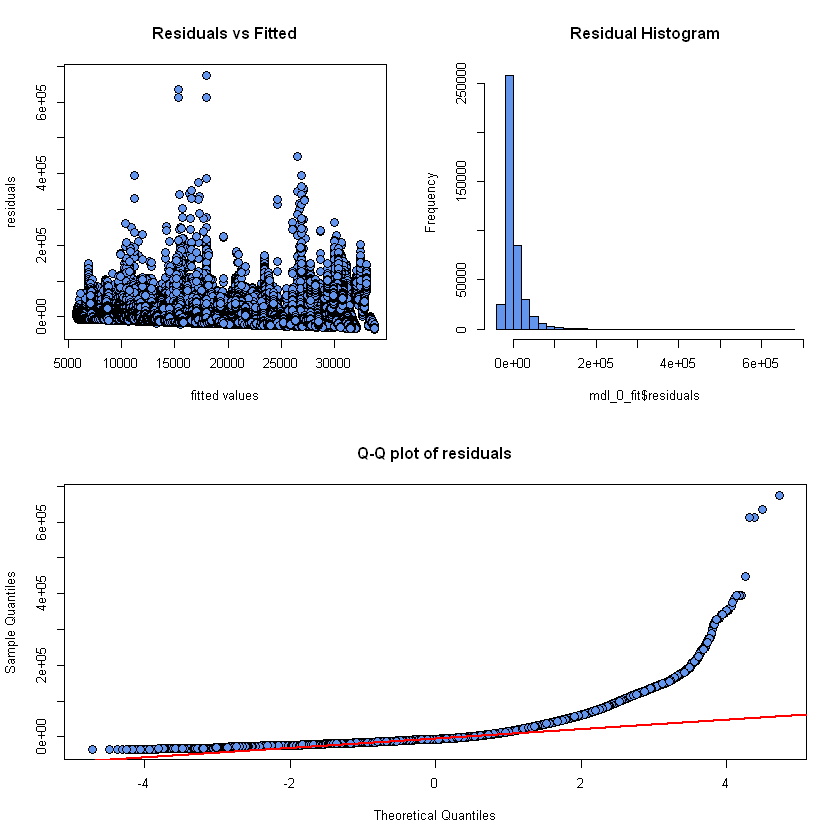

In [11]:
layout_mat <- matrix(c(1, 1, 2, 2, 3, 3, 3, 3), 
                     nrow = 2, byrow = TRUE)
layout(layout_mat)
plot( mdl_0_fit$fitted.values, mdl_0_fit$residuals, type = "p", 
      pch = 21, bg = "cornflowerblue", main = "Residuals vs Fitted", 
      ylab = "residuals", xlab = "fitted values", cex = 1.5)
hist(mdl_0_fit$residuals, col = "cornflowerblue", 
     breaks = 30, main = "Residual Histogram")
qqnorm(mdl_0_fit$residuals, main = "Q-Q plot of residuals", 
       pch = 21, bg = "cornflowerblue", cex = 1.5)
qqline(mdl_0_fit$residuals, col = "red", lwd = 2)

In [31]:
print(round(lmtest::coeftest(mdl_0_fit, sandwich::NeweyWest(mdl_0_fit, lag = 2))[, ], 5))

              Estimate Std. Error  t value Pr(>|t|)
(Intercept) 3975.53847  474.64662  8.37579  0.00000
Size           0.05096    0.00415 12.26983  0.00000
Dept          -8.29757   12.25415 -0.67712  0.49833
Size:Dept      0.00089    0.00011  7.91523  0.00000


\begin{aligned}
\underset{(se)}{\widehat{\mbox{Weekly_Sales}_i}} &= 
\underset{(474.647)}{3975.538} + 
\underset{(0.004)}{0.051} \cdot \mbox{Size}_i - 
\underset{(12.254)}{8.298} \cdot \mbox{Dept}_i + 
\underset{(0.0001)}{0.001} \cdot \mbox{Size*Dept}_i + \epsilon_i,\quad i = 1,...,N \\
\end{aligned}